For the most up to date version of this notebook, please copy from this link


---



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ZmbeTro4SqT7h_TfW63MLdqbrCUk_1br#scrollTo=KwDS9qqBbMQa)

# The section below is presented as it originally appeared
The notebook from Roboflow was initially used to give an example by training the EfficientDet on a chess dataset. The introduction will be left untouched, to provide some context.




# Overview 

💡 Recommendation: Open this blog post on [how to train EfficientDet](https://towardsdatascience.com/training-efficientdet-object-detection-model-with-a-custom-dataset-25fb0f190555) to continue.

This notebook we show an example of how to train EfficientDet using a pytorch implementation on a custom dataset that has been uploaded through RoboFlow. The example provides a flexible framework, so you can apply it to your own dataset with a custom number of classes and a different objective. We we tackle chess here. 

![Chess Example](https://i.imgur.com/nkjobw1.png)

### **Our Data and Roboflow**

Our dataset of 289 chess images (and 2894 annotations!) is hosted publicly on Roboflow [here](https://public.roboflow.ai/object-detection/chess-full). Roboflow also hosts many other public datasets and you can easily upload your own custom dataset for your use case, augment, and export in flexible formats. Our tutorial uses Coco Json, but you might have another format (say tfrecord). No problem! Upload your dataset and we will export it in the required format.

### **Model and Training**

For a deep dive on the EfficientDet model please see [the paper](https://arxiv.org/abs/1911.09070). For a shorter look, here is a great [blog post](https://towardsdatascience.com/efficientdet-scalable-and-efficient-object-detection-review-4472ffc34fd9)! 

We use a pytorch implementation of EfficientDet using the [image detection library](https://github.com/roboflow-ai/Monk_Object_Detection) from Tessellate-Imaging for object detection. Our implementation uses the base version of EfficientDet-d0.  We train from the EfficientNet base backbone, without using a pretrained checkpoint for the detector.

### **Inference**

We witness some fast inference on a few basic examples from our test set to see that our approach is heading in the right direction.

### **Export**

We export our model weights to google drive for future utilization.

### **Next Steps**

We will be exploring evaluation on custom RoboFlow datasets and objectives compared to yoloV3, including training time, inference time, model size, and performance. 

We will also explore comparing performance from the Coco pretrained checkpoint!

## **Stay in touch!**

If you run into any hurdles on your own data set or just want to share some cool results in your own domain, [reach out to us](roboflow.ai)! 

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)



# Setting up our envionment

In [ ]:
#our fork of the Tessellate-Imaging image detection library
#!rm -rf Monk_Object_Detection
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git

Cloning into 'Monk_Object_Detection'...
remote: Enumerating objects: 3794, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 3794 (delta 28), reused 31 (delta 16), pack-reused 3747
Receiving objects: 100% (3794/3794), 132.21 MiB | 29.30 MiB/s, done.
Resolving deltas: 100% (828/828), done.
Updating files: 100% (4032/4032), done.


In [ ]:
# For colab use the command below
# Set up library requirments
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 MB 3.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/abhi-kumar/cocoapi.git to /tmp/pip-install-o_qj5j26/pycocotools_824146af36d14c20bdb24ea29b5d9688
  Running command git clone --filter=blob:none --quiet https://github.com/abhi-kumar/cocoapi.git /tmp/pip-install-o_qj5j26/pycocotools_824146af36d14c20bdb24ea29b5d9688
  Resolved https://github.com/abhi-kumar/cocoapi.git to commit 1d6

In [ ]:
#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     - 91.8 kB 5.9 MB/s 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47876 sha256=f9799c457d50334429e4e7443b1c7749154e120e1793c9d0caf19b7b7c3e2f1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-e4h5jb3_/wheels/dd/d1/3a/5f30b73f63af33d7020835aff7cec9fbded1a437e67fa0fd79
Successfully built tqdm
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.5.2 requires tqdm<5.0.0,>=4.38.0, but you have tqdm 4.28.1 which is incompatible.
prophet 1.1.2 requires tqdm>=4.36.1, but you have tqdm 4.28.1 which is incompatible.
panel 0.14.4 requires tqdm>=4.

# Let's get some data!  (**Modifications start from this point**)

The best part about Roboflow is the efficient management of your datasets. [Upload you dataset](roboflow.ai) and you will recieve a fresh curl code to ouput it in whatever augmented and annotated format you need. 

Modifications begin here: Firstly, instead of using a chess dataset, our cutom-made **Engineering Front Building lift set** will be utilized. It will be obtained using the roboflow api.

Note: **Your own API key must be used**. My key will not be shared in the cell below.

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key=YOUR_OWN_API_KEY)
project = rf.workspace("uni-5xcrn").project("efb-button-detection")
dataset = project.version(2).download("coco")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=5163b30795e8d6cf654294c153bcc27dad786bc669c9d9bef090c2aaa0a566b3
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
  Attempting uninstall: pyparsing
    

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to EFB-Button-Detection-2 in coco:: 100%|██████████| 67/67 [00:00<00:00, 2128.69it/s]


In [ ]:
#let's take a look at our directory
#notice the data came down in train, valid, test, splits - this is pre set during the dataset upload process
%cd EFB-Button-Detection-2

/content/EFB-Button-Detection-2


In [ ]:
%ls train

_annotations.coco.json
image_10_png.rf.346c1af7c500d73e2e952a5aa0db6712.jpg
image_10_png.rf.44ae777e1921a0004a159b05cde2d18f.jpg
image_10_png.rf.8004a48bd0b2f2181d1beccaffca31bb.jpg
image_11_png.rf.0fc67aa0ba3075c7c2e193e82c118ae9.jpg
image_11_png.rf.395b83b31c062b038ad324e9e3b07cff.jpg
image_11_png.rf.75bf5451709fd71cfb88678123c7415e.jpg
image_12_png.rf.58b2ce680258f361ba77dc25be3df1cb.jpg
image_12_png.rf.91854dee437dd3eabc4625f1d13aa9b5.jpg
image_12_png.rf.dd030d6a5bc60ce0a1cbd53d0a0b29a5.jpg
image_13_png.rf.1444bec5d48439b7c52882a904e59c09.jpg
image_13_png.rf.89b6beca184c14b07732cf3641bc928b.jpg
image_13_png.rf.c2ebdb64c5cec9d728a69a0127614a4b.jpg
image_14_png.rf.9c96c8afd760a83c32b1dd04854a2cc8.jpg
image_14_png.rf.b04959fc4b9cfc7aa0d23aa5b8c52ed4.jpg
image_14_png.rf.dc57021dafba13ae771d08c67db8ac1a.jpg
image_16_png.rf.0f002c4517b3a90c86209756da450c8b.jpg
image_16_png.rf.9f95f5099b3506a2b83976116d9769cc.jpg
image_16_png.rf.ab8ed19589fc1a5bee5803d0a9c79f37.jpg
image_18_png.rf.13a5e8e

In [ ]:
%cd ..

/content


In [ ]:
%ls

EFB-Button-Detection-2/  Monk_Object_Detection/  sample_data/


In [ ]:
#in the next three cells, we move the data into a structure that the image detection library will be expecting
#but no file data manipulation is necessary
#images can also be segmented into class folders, but we combine all classes here
!mkdir Buttons
!mkdir Buttons/annotations
!mkdir Buttons/Annotations
!mkdir Buttons/Images


In [ ]:
%ls

Buttons/  EFB-Button-Detection-2/  Monk_Object_Detection/  sample_data/


In [ ]:
%cp EFB-Button-Detection-2/train/_annotations.coco.json Buttons/annotations/instances_Images.json

In [ ]:
%cp EFB-Button-Detection-2/train/*.jpg Buttons/Images/

# Training

In this section we set up the efficientDet-d0 model from backbone and train to our custom case

In [ ]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [ ]:
from train_detector import Detector

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
gtf = Detector();

In [ ]:
#directs the model towards file structure
root_dir = "./";
coco_dir = "Buttons";
img_dir = "./";
set_dir = "Images";

In [ ]:
#smells like some free compute from Colab, nice
gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=1, image_size=512, use_gpu=True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


In [ ]:
gtf.Model();

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 63.1MB/s]


Loaded pretrained weights for efficientnet-b0


In [ ]:
gtf.Set_Hyperparams(lr=0.0001, val_interval=1, es_min_delta=0.0, es_patience=0)

**Google Drive** needs to be **mounted** so that the model can be stored in your drive for utilizing it on different scripts.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In the cell below, training takes place. Our model was trained for **40 epochs** overall. However, due to Colab's GPU storage, it is necessary to run it on batches of 10 epochs to **prevent out-of-memory error**.

In [ ]:
%%time
gtf.Train(num_epochs=10, model_output_dir="drive/MyDrive/trained/");

  0%|          | 0/51 [00:00<?, ?it/s]

Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.


============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


  0%|          | 0/51 [00:00<?, ?it/s]

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


  0%|          | 0/51 [00:00<?, ?it/s]

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


  0%|          | 0/51 [00:00<?, ?it/s]

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


  0%|          | 0/51 [00:00<?, ?it/s]

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


  0%|          | 0/51 [00:00<?, ?it/s]

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


  0%|          | 0/51 [00:00<?, ?it/s]

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


  0%|          | 0/51 [00:00<?, ?it/s]

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


  0%|          | 0/51 [00:00<?, ?it/s]

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export


  0%|          | 0/51 [00:00<?, ?it/s]

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

faild onnx export
CPU times: user 1min 11s, sys: 4.24 s, total: 1min 16s
Wall time: 1min 32s


# Inference

In [ ]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [ ]:
from infer_detector import Infer

In [ ]:
gtf = Infer();

In [ ]:
#our trained model weights are in here in onxx format
gtf.Model(model_dir="drive/MyDrive/trained/")

In [ ]:
#extract class list from our annotations
import json
with open('EFB-Button-Detection-2/train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

In [ ]:
class_list

['elevator-buttons',
 '1',
 '2',
 '3',
 '4',
 'alarm',
 'down',
 'g',
 'key',
 'open',
 'up']

In [ ]:
%cd content

[Errno 2] No such file or directory: 'content'
/content


In [ ]:
%cd EFB-Button-Detection-2/test

/content/EFB-Button-Detection-2/test


In [ ]:
%cd ..

/content/EFB-Button-Detection-2


In [ ]:
%%time
test_images = [f for f in os.listdir('valid') if f.endswith('.jpg')]
print(test_images)
import random
img_path = "valid/" + random.choice(test_images);
print(img_path)
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2);


['image_19_png.rf.c5da998a5d29f710e0e95bd004a3cc56.jpg', 'image_2_png.rf.3c576399907fd2cda3a175d967bf4cce.jpg', 'image_22_png.rf.20880bcfc5b2ff8bb48d17f33b25d914.jpg', 'image_17_png.rf.6d8a8271035a359d048f87b43022cf07.jpg', 'image_15_png.rf.cbae7fcfa0329223256c6c6986e03f3d.jpg']
valid/image_17_png.rf.6d8a8271035a359d048f87b43022cf07.jpg
Done. (0.037s)
CPU times: user 66.9 ms, sys: 1.96 ms, total: 68.9 ms
Wall time: 69.4 ms


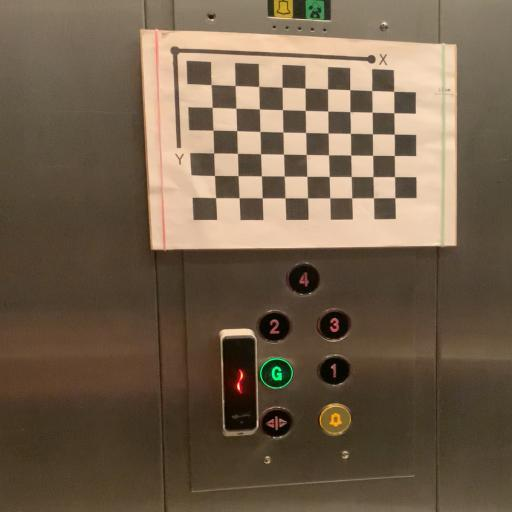

In [ ]:
from IPython.display import Image
Image(filename=img_path)

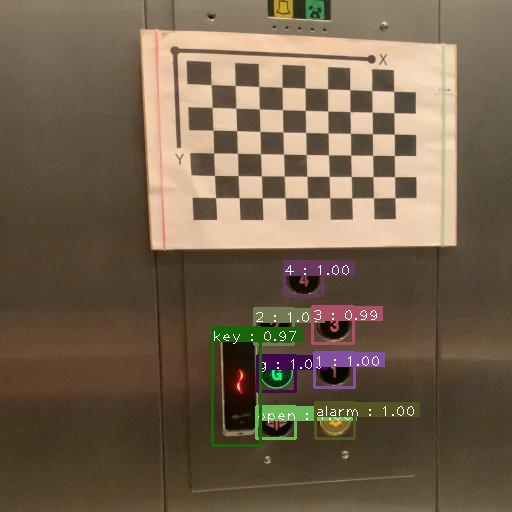

In [ ]:
from IPython.display import Image
Image(filename='output.jpg') 

# Congratulations
If you have followed the steps from this file,  you will have trained your own button recognition model.